## Optimising Travel by Train in the UK: Trend Analysis and Visualisation. 

### Introduction

The project is an analysis of data related to the sale of railway tickets. The aim of the project was to investigate various aspects such as ticket distribution, the influence of various factors on ticket prices, as well as analyze the causes and time intervals affecting the number of ticket refund requests. The project included the tasks of data collection, preparation and analysis with the use of visualization to identify key trends and patterns.

### Project Goal:
The goal of the project was to conduct comprehensive data analysis to identify key factors affecting ticket prices and refund requests, analyze traffic, and examine trends in customer behavior to improve service and streamline processes.

### Tasks:
* Data collection and preparation.
* Exploratory data analysis (EDA).
* Correlation analysis of factors.
* Analysis of causes and time intervals.
* Identification of trends in customer behavior.

### About the dataset:

The data contains mock train ticket sales for National Rail in the UK, from January to April 2024, including details on the type of ticket, the date & time for each journey, the departure & arrival stations, the ticket price, and more.

### Part 1 - Data exploration and Cleaning
So, let's start for the preparations by importing the necessary libraries and loading the dataset.

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Load the table describing each column in the dataset
description_path = 'C:\\Users\\sirad\\Work\\UKTrainRides\\dataset\\railway_data_dictionary.csv'
description = pd.read_csv(description_path)
description

,Field,Description
0,Transaction ID,Unique identifier for an individual train tick...
1,Date of Purchase,Date the ticket was purchased
2,Time of Purchase,Time the ticket was purchased
3,Purchase Type,Whether the ticket was purchased online or dir...
4,Payment Method,Payment method used to purchase the ticket (Co...
5,Railcard,Whether the passenger is a National Railcard h...
6,Ticket Class,Seat class for the ticket (Standard or First)
7,Ticket Type,When you bought or can use the ticket. Advance...
8,Price,Final cost of the ticket
9,Departure Station,Station to board the train


In [31]:
file_path = 'C:\\Users\\sirad\\Work\\UKTrainRides\\dataset\\railway.csv'
df = pd.read_csv(file_path)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31653 entries, 0 to 31652
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Transaction ID       31653 non-null  object
 1   Date of Purchase     31653 non-null  object
 2   Time of Purchase     31653 non-null  object
 3   Purchase Type        31653 non-null  object
 4   Payment Method       31653 non-null  object
 5   Railcard             10735 non-null  object
 6   Ticket Class         31653 non-null  object
 7   Ticket Type          31653 non-null  object
 8   Price                31653 non-null  int64 
 9   Departure Station    31653 non-null  object
 10  Arrival Destination  31653 non-null  object
 11  Date of Journey      31653 non-null  object
 12  Departure Time       31653 non-null  object
 13  Arrival Time         31653 non-null  object
 14  Actual Arrival Time  29773 non-null  object
 15  Journey Status       31653 non-null  object
 16  Reas

After loading the dataset, we see that many columns have an object format and I want to convert the date and time to the appropriate format in ISO 8601. 
Firstly, let's convert dates and times into a special format that helps to process and analyze them more easily. 
And then we will combine the date and time of purchase, departure and arrival into one column.

In [32]:
# Convert the dates
df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'], format='%Y-%m-%d', errors='coerce')
df['Date of Journey'] = pd.to_datetime(df['Date of Journey'], format='%Y-%m-%d', errors='coerce')

# Convert the time
df['Time of Purchase'] = pd.to_datetime(df['Time of Purchase'], format='%H:%M:%S', errors='coerce').dt.time
df['Departure Time'] = pd.to_datetime(df['Departure Time'], format='%H:%M:%S', errors='coerce').dt.time
df['Arrival Time'] = pd.to_datetime(df['Arrival Time'], format='%H:%M:%S', errors='coerce').dt.time
df['Actual Arrival Time'] = pd.to_datetime(df['Actual Arrival Time'], format='%H:%M:%S', errors='coerce').dt.time

I want to draw your attention to the need to correct the arrival time. I have added logic to correct the arrival time if the train arrives after midnight, i.e. the next day. This is needed to correctly reflect the arrival time in such cases.

In [33]:
# Connect date and time
df['Purchase Date'] = pd.to_datetime(df['Date of Purchase'].astype(str) + ' ' + df['Time of Purchase'].astype(str), format='%Y-%m-%d %H:%M:%S', errors='coerce')
df['Departure Date'] = pd.to_datetime(df['Date of Journey'].astype(str) + ' ' + df['Departure Time'].astype(str), format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Function to adjust the arrival time if it is the next day
def adjust_arrival_datetime(date, departure_time, arrival_time):
    if pd.isna(date) or pd.isna(departure_time) or pd.isna(arrival_time):
        return pd.NaT
    # Combine date and arrival time
    arrival_datetime = pd.to_datetime(str(date.date()) + ' ' + str(arrival_time), format='%Y-%m-%d %H:%M:%S', errors='coerce')
    # If arrival is earlier than departure, add one day
    if arrival_datetime.time() < departure_time:
        arrival_datetime += pd.DateOffset(days=1)
    return arrival_datetime

# Connect date and time with a function
df['Arrival Date'] = df.apply(lambda row: adjust_arrival_datetime(row['Date of Journey'], row['Departure Time'], row['Arrival Time']), axis=1)
df['Actual Arrival Date'] = df.apply(lambda row: adjust_arrival_datetime(row['Date of Journey'], row['Departure Time'], row['Actual Arrival Time']), axis=1)

# Delete old columns since they are no longer needed
df.drop(columns=['Date of Purchase', 'Time of Purchase', 'Date of Journey', 'Departure Time', 'Arrival Time', 'Actual Arrival Time'], inplace=True)

# Check dataset info again
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31653 entries, 0 to 31652
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Transaction ID       31653 non-null  object        
 1   Purchase Type        31653 non-null  object        
 2   Payment Method       31653 non-null  object        
 3   Railcard             10735 non-null  object        
 4   Ticket Class         31653 non-null  object        
 5   Ticket Type          31653 non-null  object        
 6   Price                31653 non-null  int64         
 7   Departure Station    31653 non-null  object        
 8   Arrival Destination  31653 non-null  object        
 9   Journey Status       31653 non-null  object        
 10  Reason for Delay     4172 non-null   object        
 11  Refund Request       31653 non-null  object        
 12  Purchase Date        31653 non-null  datetime64[ns]
 13  Departure Date       31653 non-

From the info above we see that we successfully have changed objects to data formats. Now let's check the table for missing values and prepare table to analysis.

In [34]:
# Check for missing values 
print(df.isnull().sum())

Transaction ID             0
Purchase Type              0
Payment Method             0
Railcard               20918
Ticket Class               0
Ticket Type                0
Price                      0
Departure Station          0
Arrival Destination        0
Journey Status             0
Reason for Delay       27481
Refund Request             0
Purchase Date              0
Departure Date             0
Arrival Date               0
Actual Arrival Date     1880
dtype: int64


We see Railcard, Actual Arrival Time and Reason for Delay are missing a lot.
1) If there is no railcard data, it can be assumed that the passenger is not a railcard holder, so I will fill missing values with 'None' value.
2) Lots of missing values in Actual Arrival Time I will fill in adding the mean of difference between 'Arrival Date' and 'Actual Arrival Date'
3) Reason for Delay column I will fill missing values with 'None' value, because there is no reason for delay


In [35]:
# Fill missing values with 'None'
df.fillna({'Railcard': 'None'}, inplace=True)
df.fillna({'Reason for Delay': 'None'}, inplace=True)

In [36]:
# Calculate the difference between 'Arrival Date' and 'Actual Arrival Date'
df['Difference'] = df['Actual Arrival Date'] - df['Arrival Date']

# Calculate the average difference, ignoring NaN values
average_difference = df['Difference'].mean()
print("Average difference:", average_difference)

# Fill missing values in 'Actual Arrival Date' with the average difference
df['Actual Arrival Date'] = df.apply(
    lambda row: (row['Arrival Date'] + average_difference).strftime('%Y-%m-%d %H:%M') if pd.isnull(row['Actual Arrival Date']) else row['Actual Arrival Date'].strftime('%Y-%m-%d %H:%M'),
    axis=1
)
# Drop the temporary 'Difference' column if no longer needed
df.drop(columns=['Difference'], inplace=True)

# Check for missing values again
print(df.isnull().sum())

Average difference: 0 days 00:03:14.981358949
Transaction ID         0
Purchase Type          0
Payment Method         0
Railcard               0
Ticket Class           0
Ticket Type            0
Price                  0
Departure Station      0
Arrival Destination    0
Journey Status         0
Reason for Delay       0
Refund Request         0
Purchase Date          0
Departure Date         0
Arrival Date           0
Actual Arrival Date    0
dtype: int64


In [37]:
# Since we have cleaned and prepared data, let's save it separately.

# Reorder columns
df = df[['Transaction ID', 'Purchase Date', 'Purchase Type', 'Payment Method', 'Railcard', 'Ticket Class', 'Ticket Type', 'Price', 'Departure Station', 'Arrival Destination', 'Departure Date', 'Arrival Date', 'Actual Arrival Date', 'Journey Status', 'Reason for Delay', 'Refund Request']]

df.to_csv('C:\\Users\\sirad\\Work\\UKTrainRides\\dataset\\railway_formatted.csv', index=False)

This part is finished, let's continue Exploratory Data Analysis (EDA) and Visualisation in the second part of my project

### Part 2 - Exploratory Data Analysis (EDA)

I will load the new table and see unique values for some categorical columns

In [38]:
#Load new table
file_path = 'C:\\Users\\sirad\\Work\\UKTrainRides\\dataset\\railway_formatted.csv'
df = pd.read_csv(file_path)

categorical_columns = ['Purchase Type', 'Payment Method', 'Railcard', 'Ticket Type', 'Ticket Class', 'Journey Status', 'Reason for Delay', 'Refund Request']

# View unique values for categorical variables
for column in categorical_columns:
    print(f"Unique values in the {column}:")
    print(df[column].unique())

Unique values in the Purchase Type:
['Online' 'Station']
Unique values in the Payment Method:
['Contactless' 'Credit Card' 'Debit Card']
Unique values in the Railcard:
['Adult' nan 'Disabled' 'Senior']
Unique values in the Ticket Type:
['Advance' 'Off-Peak' 'Anytime']
Unique values in the Ticket Class:
['Standard' 'First Class']
Unique values in the Journey Status:
['On Time' 'Delayed' 'Cancelled']
Unique values in the Reason for Delay:
[nan 'Signal Failure' 'Technical Issue' 'Weather Conditions' 'Weather'
 'Staffing' 'Staff Shortage' 'Signal failure' 'Traffic']
Unique values in the Refund Request:
['No' 'Yes']


#### 1. Visualization of the distribution of ticket prices by class, ticket type, and railcard

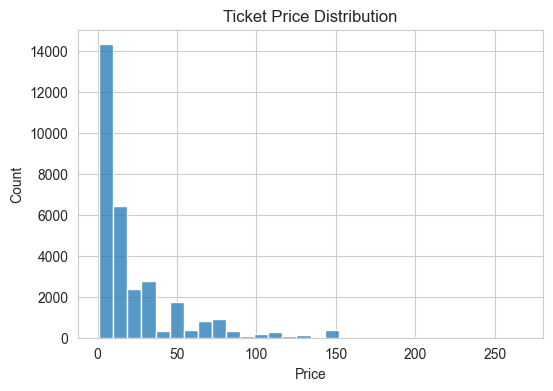

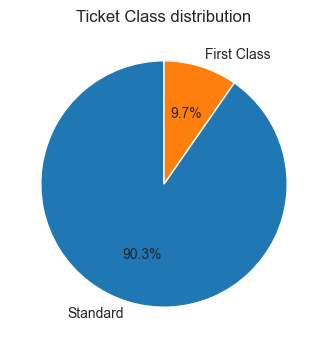

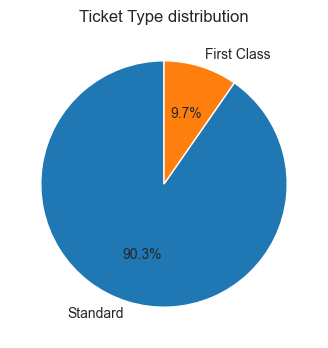

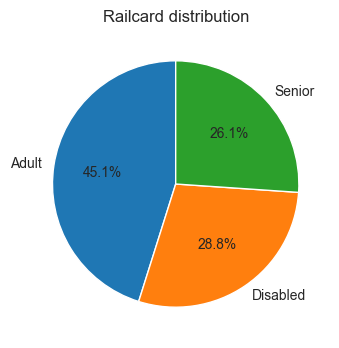

In [39]:
# Data Visualization using plots for Price
plt.figure(figsize=(6, 4))
sns.histplot(df['Price'], bins=30)
plt.title('Ticket Price Distribution')
plt.show()

# Data Visualization using pie charts for categorical columns
plt.figure(figsize=(4, 4))
df['Ticket Class'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title(f'Ticket Class distribution')
plt.ylabel('')
plt.show()

plt.figure(figsize=(4, 4))
df['Ticket Class'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title(f'Ticket Type distribution')
plt.ylabel('')
plt.show()

plt.figure(figsize=(4, 4))
df['Railcard'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title(f'Railcard distribution')
plt.ylabel('')
plt.show()

There are visualizing of distribution of Ticket Price and pie plots of Ticket Class, Ticket Type and Railcard.
Let's see the distribution of ticket classes (Standard vs. First) and ticket types (Advance, Off-Peak, Anytime) together connected.

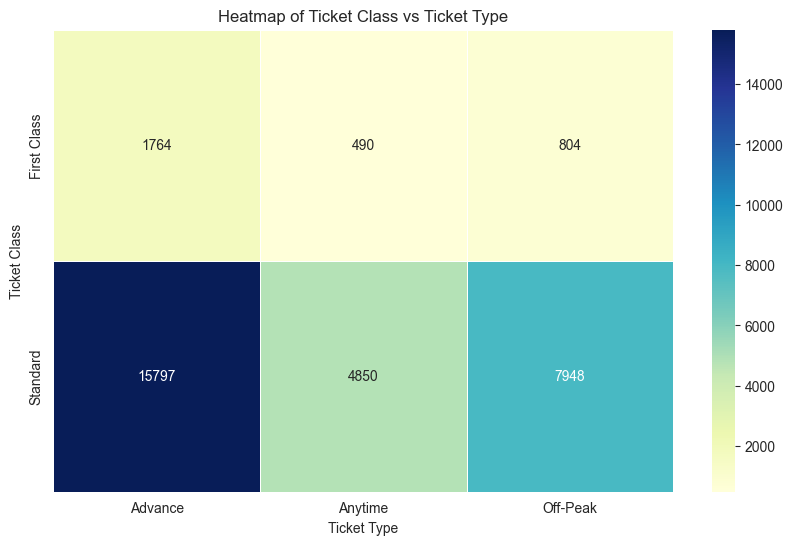

In [40]:
# Creating a summary table to analyze distribution by Ticket Class and Ticket Type
distribution_by_class_and_type = pd.pivot_table(df, values='Price', index='Ticket Class', columns='Ticket Type', aggfunc='count', fill_value=0)

# Visualizing the pivot-table
plt.figure(figsize=(10, 6))
sns.heatmap(distribution_by_class_and_type, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap of Ticket Class vs Ticket Type')
plt.xlabel('Ticket Type')
plt.ylabel('Ticket Class')
plt.show()

**Conclusion of distribution of Ticket Prices by Class, Ticket Type, and Railway Card:**
Standard Class has a significantly higher number of tickets and a higher proportion of all ticket types compared to First Class.

For both classes, the Advance ticket type predominates. This may mean that customers are more likely to buy tickets in advance, perhaps to get better prices or to guarantee a seat. Off-Peak and Anytime tickets make up a smaller proportion, but are more popular in the case of Standard than First Class.

#### 2. Correlation analysis of the impact of Railway Card, Ticket Types, and Classes on Price

Now, I will perform a correlation analysis to understand how different Railcard types, Ticket Types and Class affect Price. Correlation analysis allows us to identify the relationship between numerical variables and helps us to understand which factors have the greatest impact on the price.

Firstly, I will apply the one-hot encoding technique to the categorical columns 'Railcard' and 'Ticket Type' to convert categorical variables to numeric values. 

P.S. The categorical variables 'Purchase Type', 'Ticket Class' and 'Payment Method' contain mutually exclusive values, so their inclusion in the correlation analysis is not useful. Mutually exclusive variables will always have a strong negative correlation, which does not add useful information to the analysis and may create collinearity in the models.

In [41]:
# Apply one-hot encoding to categorical columns
df_encoded = pd.get_dummies(df[['Price', 'Railcard', 'Ticket Type']], columns=['Railcard', 'Ticket Type'])

# Display the correlation between price and other columns
correlation_with_price = df_encoded.corr()['Price']
print(correlation_with_price)

Price                   1.000000
Railcard_Adult         -0.079721
Railcard_Disabled      -0.071425
Railcard_Senior        -0.133572
Ticket Type_Advance    -0.216876
Ticket Type_Anytime     0.236639
Ticket Type_Off-Peak    0.042851
Name: Price, dtype: float64


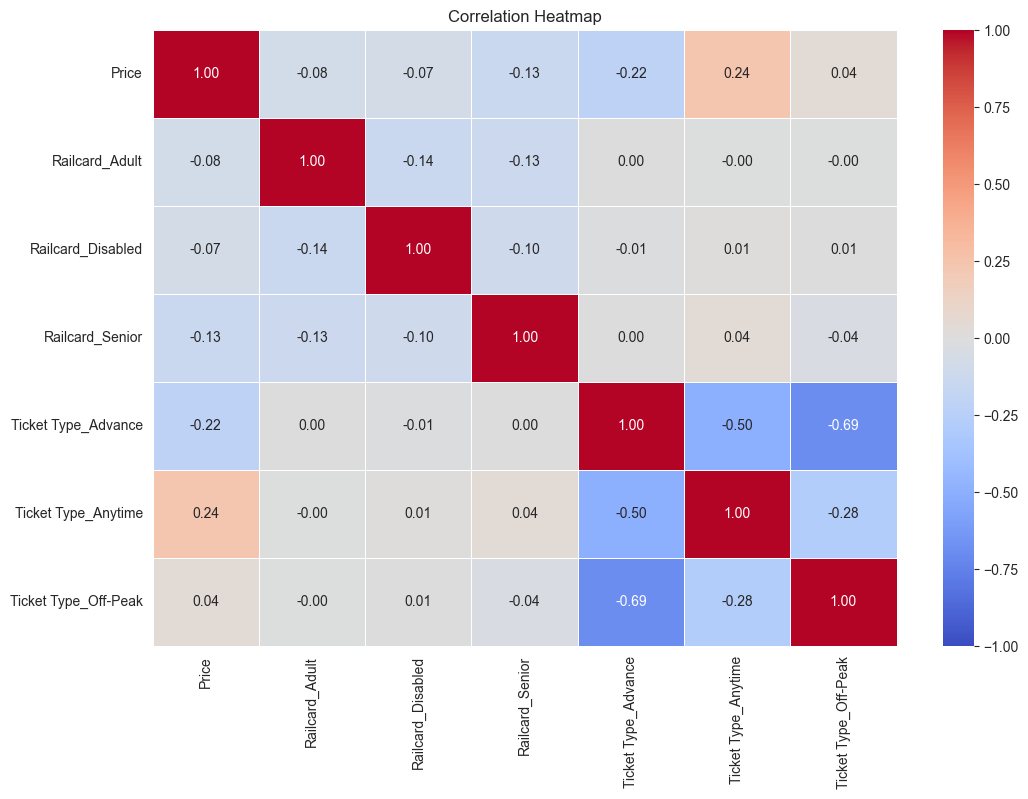

In [42]:
# Heatmap of the entire correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

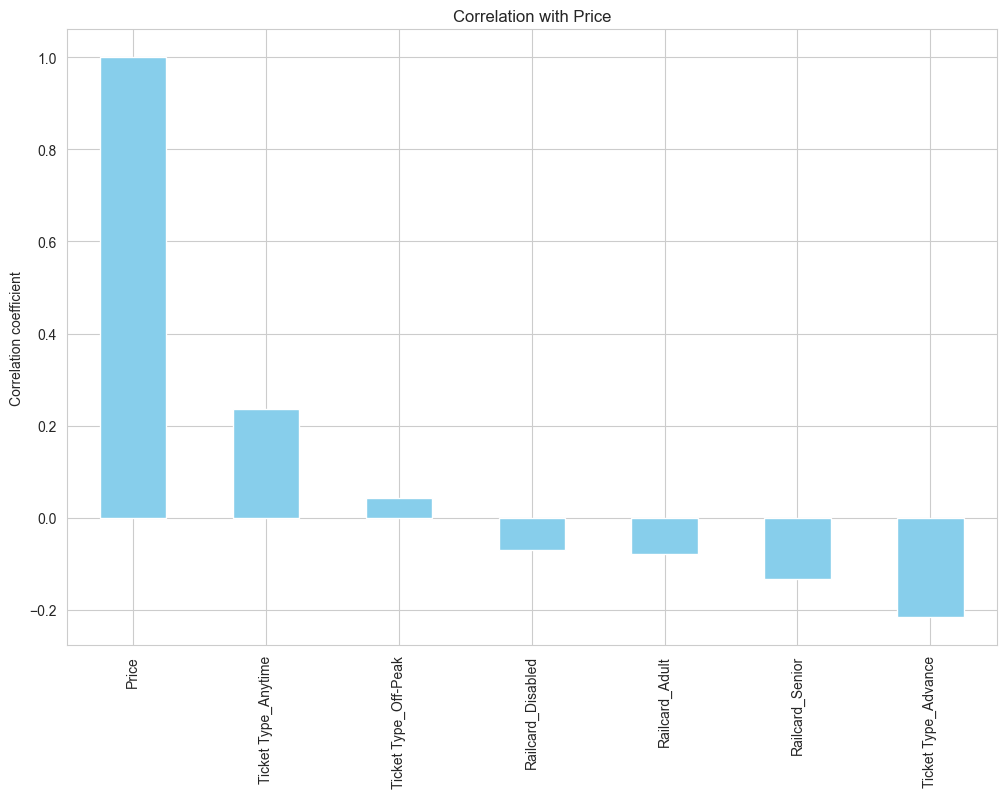

In [43]:
# Bar plot of correlation with Price
plt.figure(figsize=(12, 8))
correlation_with_price.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Correlation with Price')
plt.ylabel('Correlation coefficient')
plt.show()

**Conclusion of correlation analysis of the impact of Railway Card, Ticket Types, and Classes on Price:**
So, after performing correlation analysis I would answer next three questions:
1. **How does having a travel card affect the price of a ticket?**
Passengers with adult, disabled or elderly travel cards tend to pay less, but the relationship with price is not strong.

2. **How does the price change depending on the type of ticket: Advance, Anytime or Off-peak?**
Advance tickets are usually cheaper than tickets bought on the day of travel. Tickets that can be used at any time (Anytime) are more expensive. Off-Peak tickets are almost the same price as other types of tickets.

3. **Which factors have a more significant impact on the price of a ticket?**
Ticket type has a more pronounced effect on price compared to the availability of travel cards. For example, pre-purchased tickets have a larger negative correlation with price compared to the availability of travel cards.

**The impact of Ticket Price on Class and Ticket Type?**
I'd like to expand the answer to the 2. question above and determine the average ticket price and examine how it varies by Ticket Class and Ticket Type by grouping data and calculating averages. Firstly, let's see the distribution of Ticket Type.

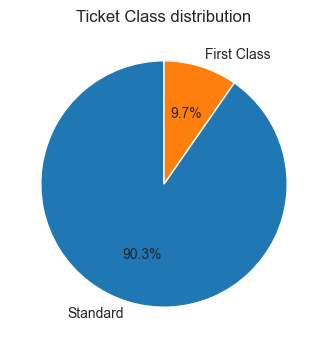

In [44]:
# Visualization of ticket class
plt.figure(figsize=(4, 4))
df['Ticket Class'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title(f'Ticket Class distribution')
plt.ylabel('')
plt.show()

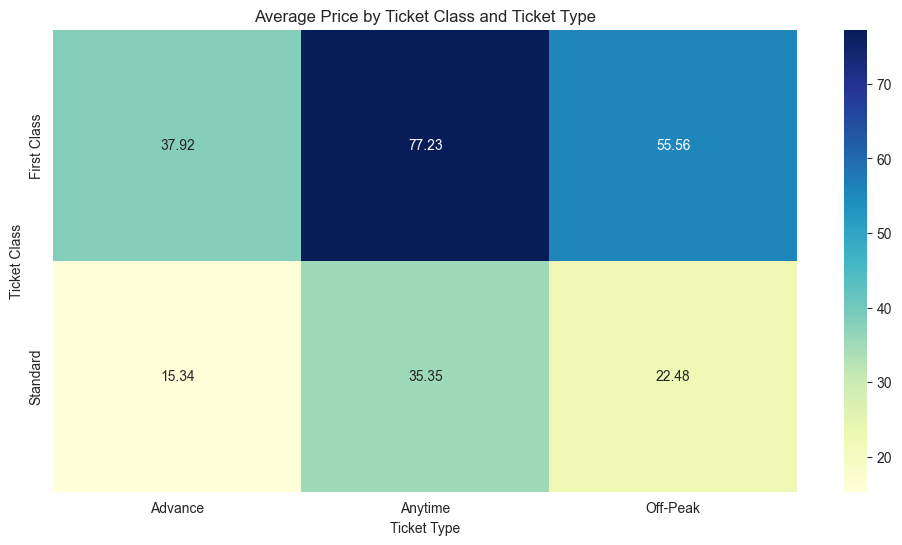

In [45]:
# Average price by Class and Ticket Type
mean_price_by_class_and_type = df.groupby(['Ticket Class', 'Ticket Type'])['Price'].mean().unstack()

# Visualization of average price
plt.figure(figsize=(12, 6))
sns.heatmap(mean_price_by_class_and_type, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Average Price by Ticket Class and Ticket Type')
plt.xlabel('Ticket Type')
plt.ylabel('Ticket Class')
plt.show()

**Conclusion of the impact of Ticket Price on Class and Ticket Type:**
First class is significantly more expensive than standard class for all types of tickets. In particular, the average price of a ticket in first class is two to three times higher than in standard class. 

Anytime tickets have the highest average price, while Advance tickets are the cheapest for all classes. Off-Peak tickets have intermediate prices, which reflects their use at less busy times when demand and therefore price is lower.

### 3. Journey and Timing Correlations

Firstly, let's define unique values for Arrival and Departure Stations and determine which stations are the most common departure and arrival points?

In [46]:
print("Arrival Destination is: ", df['Arrival Destination'].unique())
print("Departure Station is: ", df['Departure Station'].unique())

Arrival Destination is:  ['Liverpool Lime Street' 'York' 'Manchester Piccadilly' 'Reading'
 'London Euston' 'Oxford' 'Durham' 'London St Pancras'
 'Birmingham New Street' 'London Paddington' 'Bristol Temple Meads'
 'Tamworth' 'London Waterloo' 'Sheffield' 'Wolverhampton' 'Leeds'
 'Stafford' 'Doncaster' 'Swindon' 'Nottingham' 'Peterborough' 'Edinburgh'
 'Crewe' 'London Kings Cross' 'Leicester' 'Nuneaton' 'Didcot'
 'Edinburgh Waverley' 'Coventry' 'Wakefield' 'Cardiff Central'
 'Warrington']
Departure Station is:  ['London Paddington' 'London Kings Cross' 'Liverpool Lime Street'
 'London Euston' 'York' 'Manchester Piccadilly' 'Birmingham New Street'
 'London St Pancras' 'Oxford' 'Reading' 'Edinburgh Waverley'
 'Bristol Temple Meads']


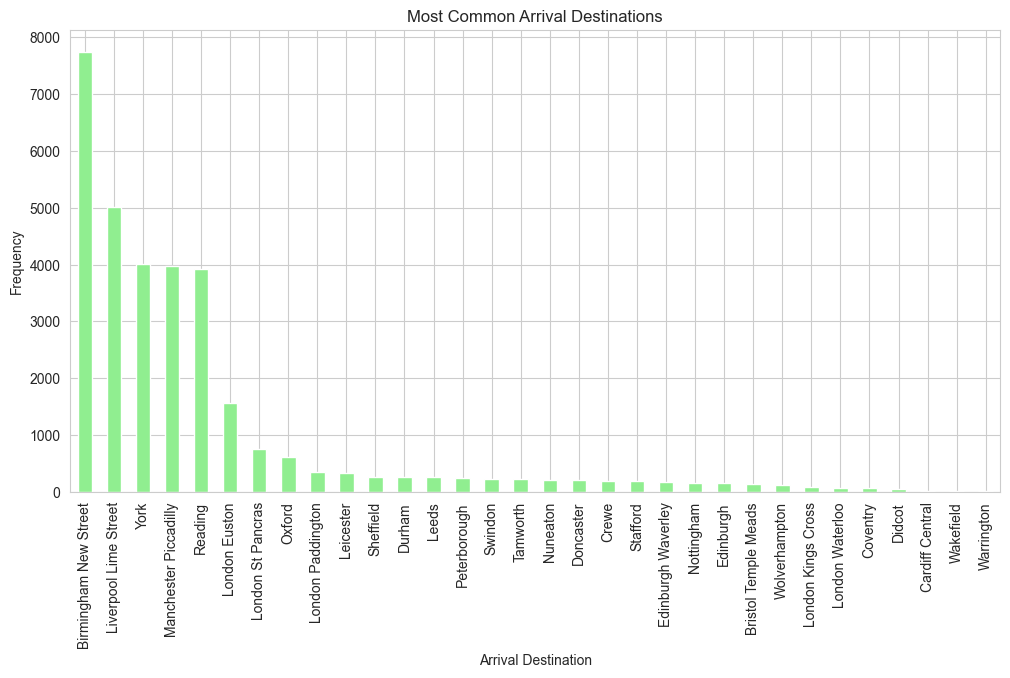

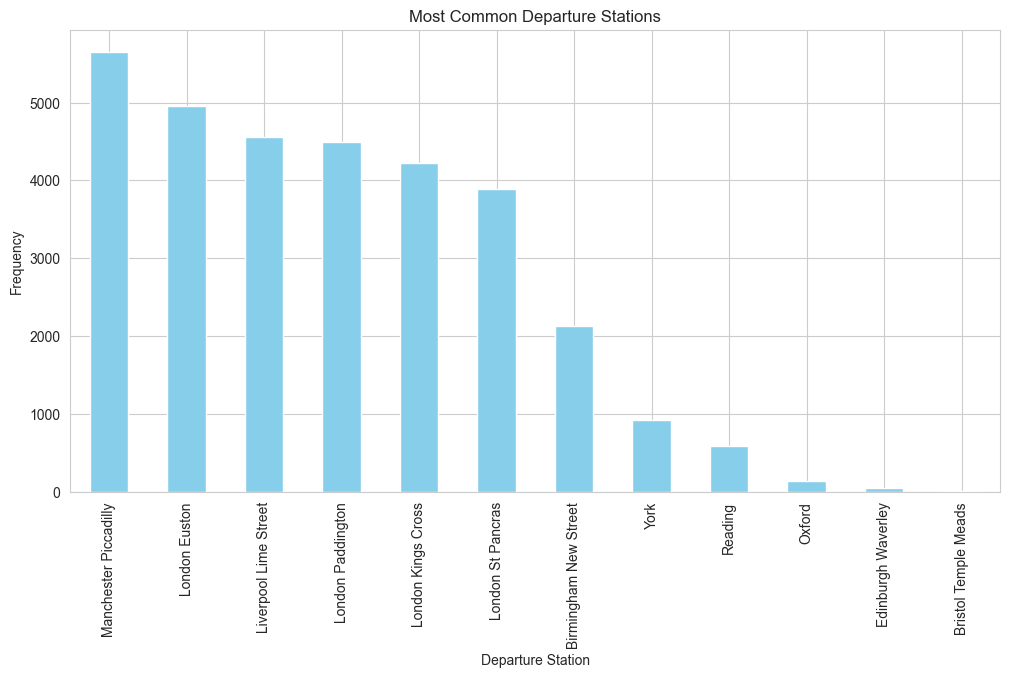

In [47]:
# Visualization of arrival and departure station frequency
plt.figure(figsize=(12, 6))
df['Arrival Destination'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Most Common Arrival Destinations')
plt.xlabel('Arrival Destination')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
df['Departure Station'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Most Common Departure Stations')
plt.xlabel('Departure Station')
plt.ylabel('Frequency')
plt.show()

So, now we can see five the most popular stations are common for arrival and departure.
Finally, let's define the distribution of departed and arrival times to analise the peak period occurrence and the trips distribution throughout the day. 
I will normalize the data and split the day on 3-hours intervals before the calculation of trips during each interval.

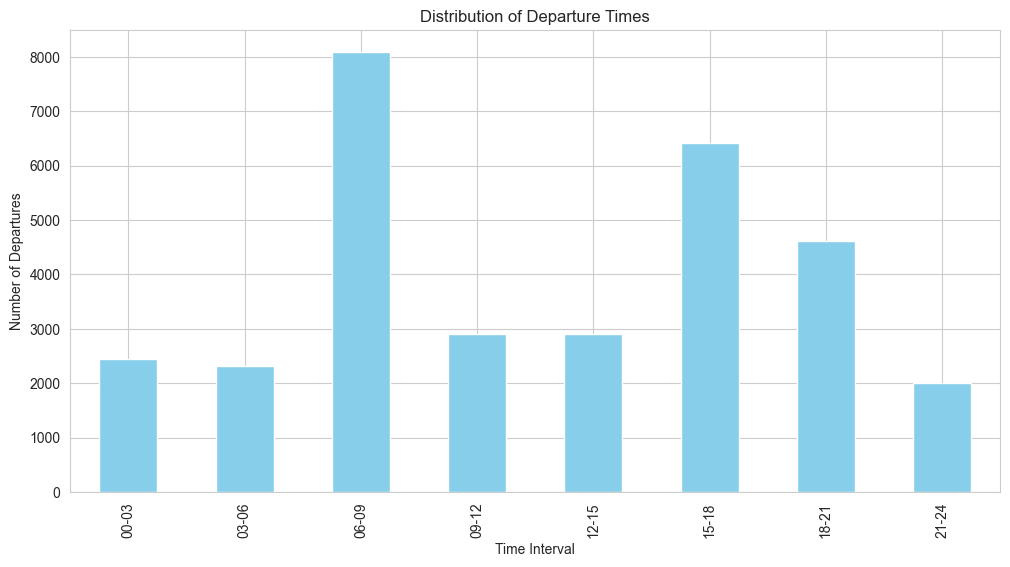

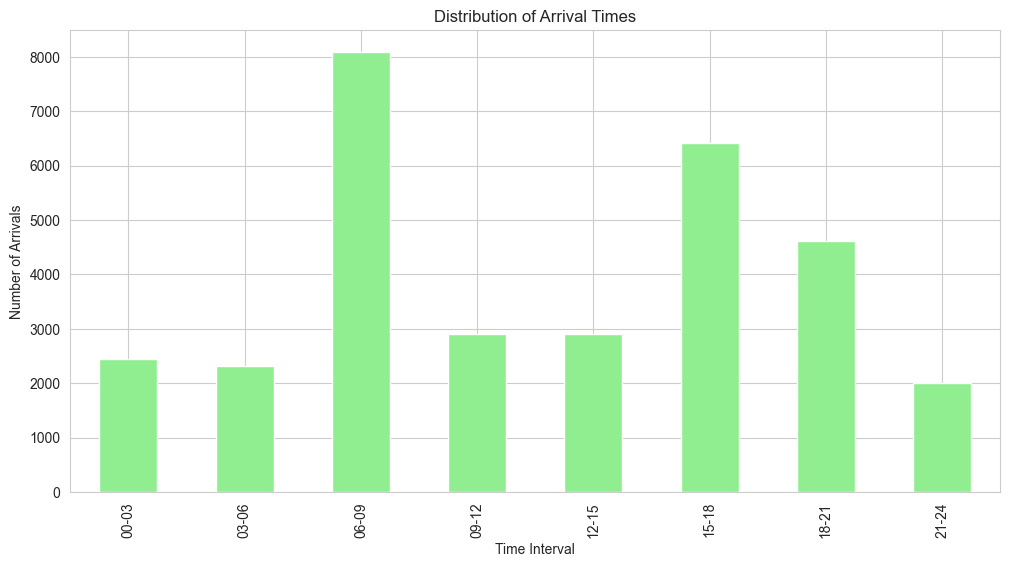

In [48]:
# Extract time from timestamps from converted columns to datetime format
df['Departure Hour'] = pd.to_datetime(df['Departure Date']).dt.hour
df['Arrival Hour'] = pd.to_datetime(df['Departure Date']).dt.hour

# Define 3-hour intervals
bins = [0, 3, 6, 9, 12, 15, 18, 21, 24]
labels = ['00-03', '03-06', '06-09', '09-12', '12-15', '15-18', '18-21', '21-24']

df['Departure Interval'] = pd.cut(df['Departure Hour'], bins=bins, labels=labels, right=False)
df['Arrival Interval'] = pd.cut(df['Arrival Hour'], bins=bins, labels=labels, right=False)

# Count the number of trips in each interval
departure_distribution = df['Departure Interval'].value_counts().sort_index()
arrival_distribution = df['Arrival Interval'].value_counts().sort_index()

# Visualize results
plt.figure(figsize=(12, 6))
departure_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Departure Times')
plt.xlabel('Time Interval')
plt.ylabel('Number of Departures')
plt.show()

plt.figure(figsize=(12, 6))
arrival_distribution.plot(kind='bar', color='lightgreen')
plt.title('Distribution of Arrival Times')
plt.xlabel('Time Interval')
plt.ylabel('Number of Arrivals')
plt.show()

**Conclusions:**
So, after performing correlation analysis I would answer next questions:

1. **When do peak departures and arrivals occur?**
The main peaks of activity occur during the morning for both cases (06:00-09:00) and evening (15:00-28:00 - for arrival case, 18:00-21:00 - departure case) hours. That is before and after business (office) hours. 

2. **How are trips distributed throughout the day?**
-- The morning hours (06:00-09:00) are the highest level of departures. This is also one of the peak intervals for arrivals.
-- Afternoon hours (09:00-15:00) - moderate activity, with a notable peak between 12:00-15:00 for departures, but with a less significant peak for arrivals.
-- Evening hours (18:00-21:00) - high levels of arrivals but fewer departures, which may indicate evening returns home.
-- Night hours (00:00-06:00) - lowest activity for both departures and arrivals.

3. **How can the schedule be optimized to improve service?**
Increase the frequency of flights during morning and evening hours to cope with high levels of departures. Reduce the frequency of flights during night hours, where activity is minimal.

#### 4. Delay and Cancellation Correlations

Firstly let's define how often do trains arrive on time versus delayed or canceled? Then I wil analyze common Reasons for Delays or cancellations and finally determine how do delay durations vary by reason and time of day?

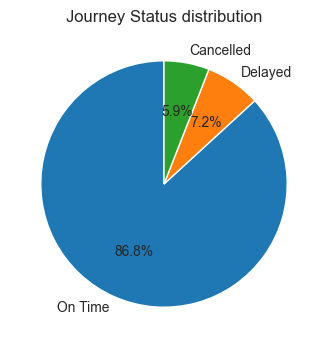

In [49]:
# Visualization of Journey Status
plt.figure(figsize=(4, 4))
df['Journey Status'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title(f'Journey Status distribution')
plt.ylabel('')
plt.show()

From the defining unique values in the beginning we have seen that column Reason for Delay is not normalized, because it has the same meanings (e.g., 'Signal Failure' vs. 'Signal failure').

Unique values in the Reason for Delay:
[nan 'Signal Failure' 'Technical Issue' 'Weather Conditions' 'Weather'
 'Staffing' 'Staff Shortage' 'Signal failure' 'Traffic']
 
So, before the analyzing common reasons for delays or cancellations, I would normalize and filtered out the columns.

[nan 'Signal Failure' 'Technical Issue' 'Weather Conditions'
 'Staff Shortage' 'Traffic']


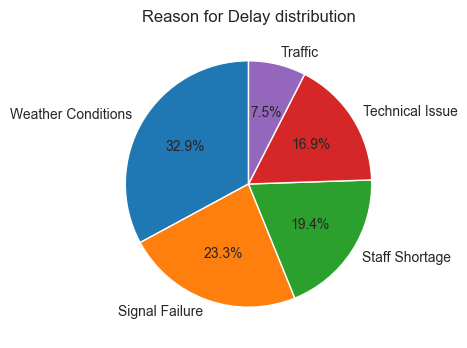

In [50]:
# Normalize the 'Reason for Delay' values
df['Reason for Delay'] = df['Reason for Delay'].replace({
    'Signal failure': 'Signal Failure',
    'Weather': 'Weather Conditions',
    'Staffing': 'Staff Shortage'
})
print(df['Reason for Delay'].unique())

# Visualization of Reason for Delay
plt.figure(figsize=(4, 4))
df['Reason for Delay'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title(f'Reason for Delay distribution')
plt.ylabel('')
plt.show()

# Update the table
df.to_csv('C:\\Users\\sirad\\Work\\UKTrainRides\\dataset\\railway_formatted.csv', index=False)

For the analysis of Delay Durations by Reason and Time of Day I will use some logic for splitting the day by intervals from the previous question. After calculating the delay difference again, I'm going to group the reasons and overlay the results over intervals.

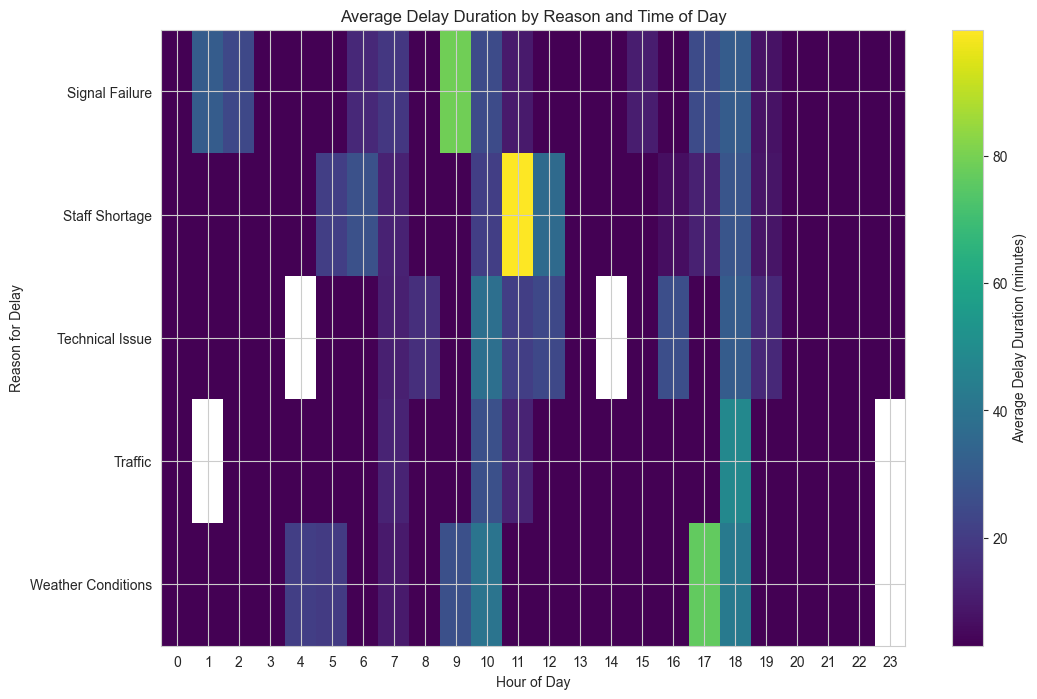

In [51]:
# Convert to datetime
df['Arrival Date'] = pd.to_datetime(df['Arrival Date'])
df['Actual Arrival Date'] = pd.to_datetime(df['Actual Arrival Date'])

# Calculate delay duration in minutes
df['Delay Duration'] = (df['Actual Arrival Date'] - df['Arrival Date']).dt.total_seconds() / 60

# Extract hour from scheduled arrival date
df['Hour of Day'] = df['Arrival Date'].dt.hour

# Group by Reason for Delay and Hour of Day
grouped_df = df.groupby(['Reason for Delay', 'Hour of Day'])['Delay Duration'].mean().unstack()

# Plot the heatmap
plt.figure(figsize=(12, 8))
plt.imshow(grouped_df, cmap='viridis', aspect='auto', interpolation='none')
plt.colorbar(label='Average Delay Duration (minutes)')
plt.title('Average Delay Duration by Reason and Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Reason for Delay')
plt.xticks(ticks=range(24), labels=range(24))
plt.yticks(ticks=range(len(grouped_df.index)), labels=grouped_df.index)
plt.show()

**Signal Failure:**
Delays due to signal failure are spread throughout the day, with significant delays in the early morning (around 0-1 AM) and late morning to early afternoon (around 10-11 AM).
The average delay duration for signal failures tends to be moderate, generally below 40 minutes.

**Staff Shortage:**
Delays due to staff shortage are concentrated more around the midday hours, especially from 11 AM to 2 PM.
There is a notable spike in the average delay duration around 11 AM, with delays exceeding 80 minutes. This indicates a significant impact on service during this time.

**Technical Issue:**
Technical issues causing delays are observed in the early morning (around 3-4 AM) and then again in the afternoon (around 5-7 PM).
The average delay duration for technical issues tends to be relatively high in these periods, with some delays reaching up to 60 minutes or more.

**Traffic:**
Delays caused by traffic are less frequent but occur during early morning (around 4 AM), late afternoon (around 5-6 PM), and late night (around 10-11 PM).
The average delay duration due to traffic tends to be lower than other reasons, generally below 30 minutes.

**Weather Conditions:**
Weather-related delays are more dispersed but notable in the early morning (around 6-7 AM) and late evening (around 5-6 PM).
The average delay duration for weather conditions can vary, with some significant delays exceeding 60 minutes during peak hours.

**Conclusion of variation in length of delay by cause and time of day:**
Significant delays occur during specific hours of the day depending on the reason. For instance, staff shortages cause the most significant delays around midday, highlighting a critical period where additional staffing resources might be necessary to minimize disruptions.

Technical issues tend to cause delays during early morning and evening hours. Ensuring technical support is available during these times could help mitigate these delays.

Delays due to weather are less predictable but can have significant impacts during peak travel times.

#### 5. Refund Request Correlations

**How frequently do passengers request refunds after delays or cancellations?**
Firstly I'm going to identify which records in the dataset correspond to delays or cancellations and then calculate the frequency of refund requests related to delays or cancellations.

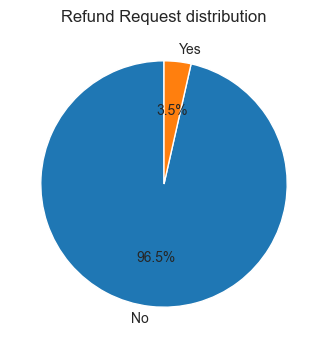

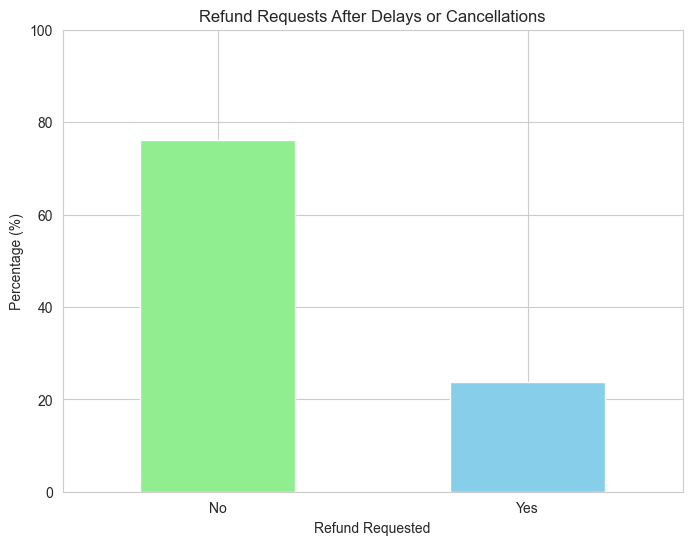

In [52]:
# Visualization of Refund Request
plt.figure(figsize=(4, 4))
df['Refund Request'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title(f'Refund Request distribution')
plt.ylabel('')
plt.show()

# Filter records for delays and cancellations
delays_cancellations = df[df['Journey Status'].isin(['Delayed', 'Canceled'])]

# Calculate the frequency of refund requests
refund_frequency = delays_cancellations['Refund Request'].value_counts(normalize=True) * 100

# Visualize the results
plt.figure(figsize=(8, 6))
refund_frequency.plot(kind='bar', color=['lightgreen', 'skyblue'])
plt.title('Refund Requests After Delays or Cancellations')
plt.xlabel('Refund Requested')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)
plt.show()

**Is there a correlation between the length of the delay and the likelihood of a Refund Request?**
To determine it firstly I will convert Refund Requested values to binary and calculate the correlation between these two variables.

Correlation between Delay Duration and Refund Requested: 0.11


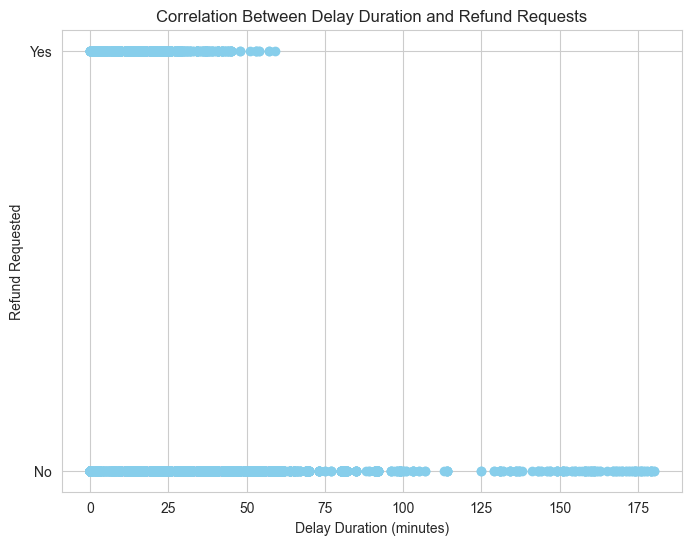

In [53]:
# Convert 'Refund Requested' to binary values
df['Refund Requested Binary'] = df['Refund Request'].map({'No': 0, 'Yes': 1})

# Calculate the correlation
correlation = df['Delay Duration'].corr(df['Refund Requested Binary'])
print(f'Correlation between Delay Duration and Refund Requested: {correlation:.2f}')

# Visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(df['Delay Duration'], df['Refund Request'], color='skyblue')
plt.title('Correlation Between Delay Duration and Refund Requests')
plt.xlabel('Delay Duration (minutes)')
plt.ylabel('Refund Requested')
plt.yticks([0, 1], ['No', 'Yes'])
plt.grid(True)
plt.show()

**Conclusion of correlation between the delay and Refund Request:**
The correlation coefficient of 0.11 indicates a weak positive correlation between delay duration and the likelihood of a refund request. This suggests that, generally, as the delay duration increases, there is a slight increase in the likelihood of a refund request, but the relationship is not strong

The graph shows that most refund requests occur even for short delays (less than 50 minutes), but also for longer delays (more than 50 minutes), but their number does not increase significantly as the length of the delay increases.

It is likely that other factors such as the reason for the delay, Ticket Type, and other factors will also affect refund requests. Let's check the correlation between Refund Requests, Time of day and Reason for Delay.

**Relationship between Refund Requests by Reason for Delay and Time of Day**
To analyze the relationship between refund requests, time of day, and the reason for delay, I will create a heatmap that includes the binary 'Refund Requested' column. First, let's group the data by Reason for Delay and Hour of Day, and then calculate the mean of Refund Requested to see how likely refunds are requested at different times for different delay reasons.

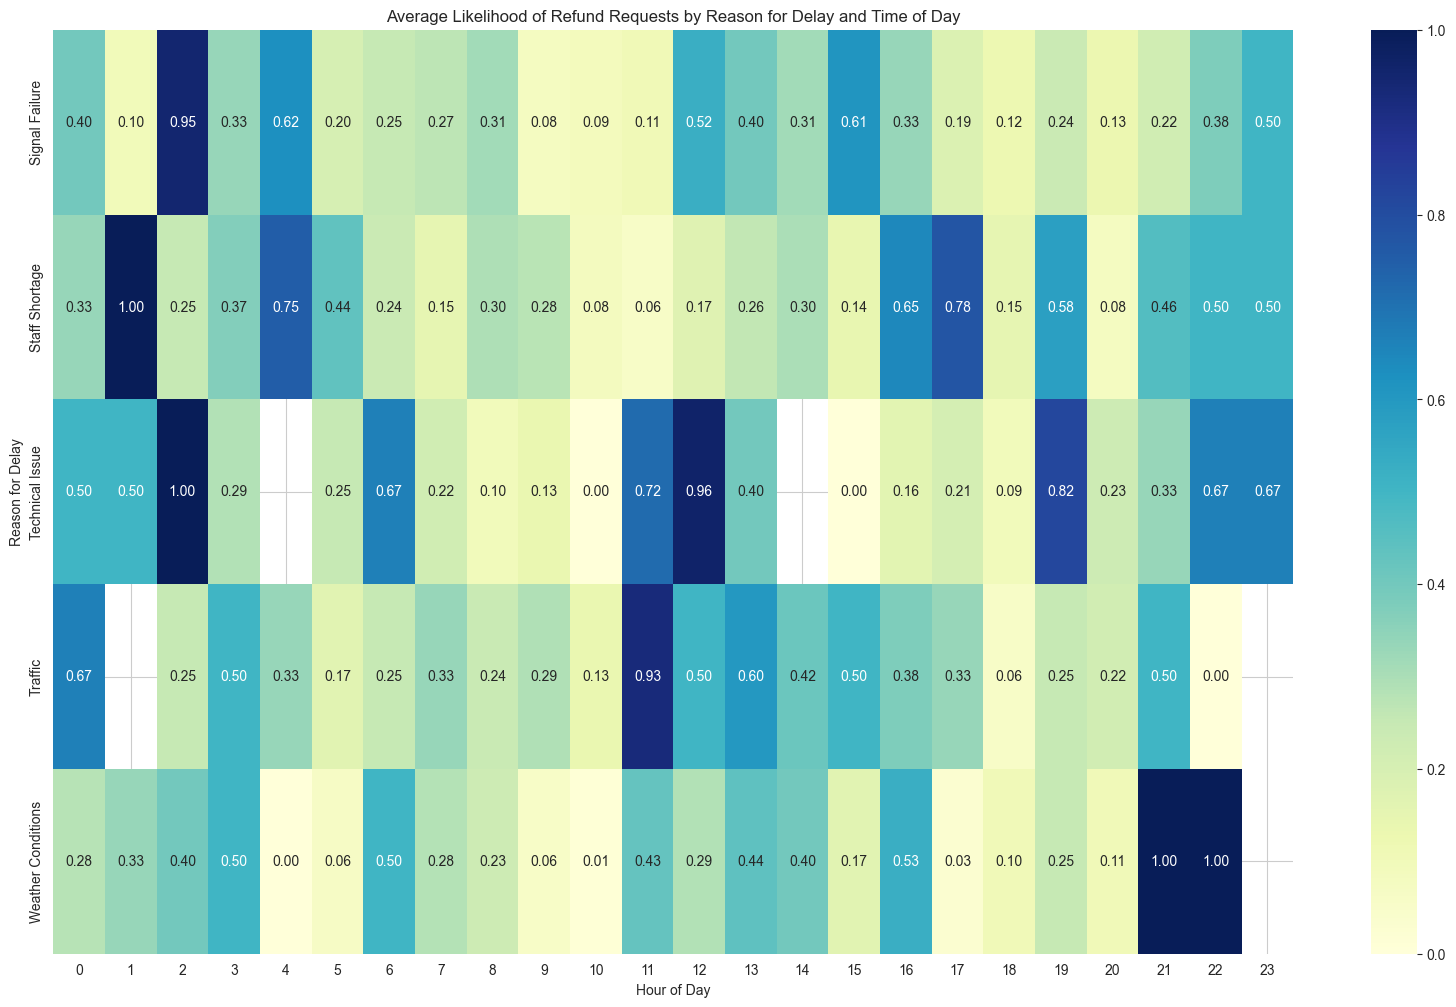

In [54]:
# Group by Reason for Delay and Hour of Day, then calculate the mean of Refund Requested Binary
grouped_refund_df = df.groupby(['Reason for Delay', 'Hour of Day'])['Refund Requested Binary'].mean().unstack()

# Create the heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(grouped_refund_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Average Likelihood of Refund Requests by Reason for Delay and Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Reason for Delay')
plt.show()

**Signal Failure:**
* High likelihood of refund requests during the early morning hours (2 AM: 95.2%).
* Noticeable decrease during the typical working hours (9 AM - 6 PM).
* Peaks again in the late evening (10 PM - 12 AM).

**Staff Shortage:**
* Very high likelihood of refund requests during the early morning hours (1 AM: 100%).
* Another peak in the early evening (5 PM: 77.6%).
* Decreased likelihood during mid-morning to early afternoon (9 AM - 3 PM).

**Technical Issue:**
* Extremely high likelihood during the early morning hours (2 AM: 100%).
* Significantly lower during typical working hours and afternoon.
* High again late at night (7 PM and 10 PM: 81.7% and 66.7%, respectively).

**Traffic:**
* High likelihood during the early morning (12 AM, 3 AM) but with some gaps in the data.
* Moderate throughout the day with a slight peak in the late afternoon (2 PM: 41.7%).

**Weather Conditions:**
* Variable throughout the day, with some high peaks in late night hours (10 PM - 11 PM: 100%).
* Relatively low likelihood during early morning and typical working hours.

Let's create a simpler and more intuitive bar plot to understand the relationship by Reason for Delay and Time of Day.

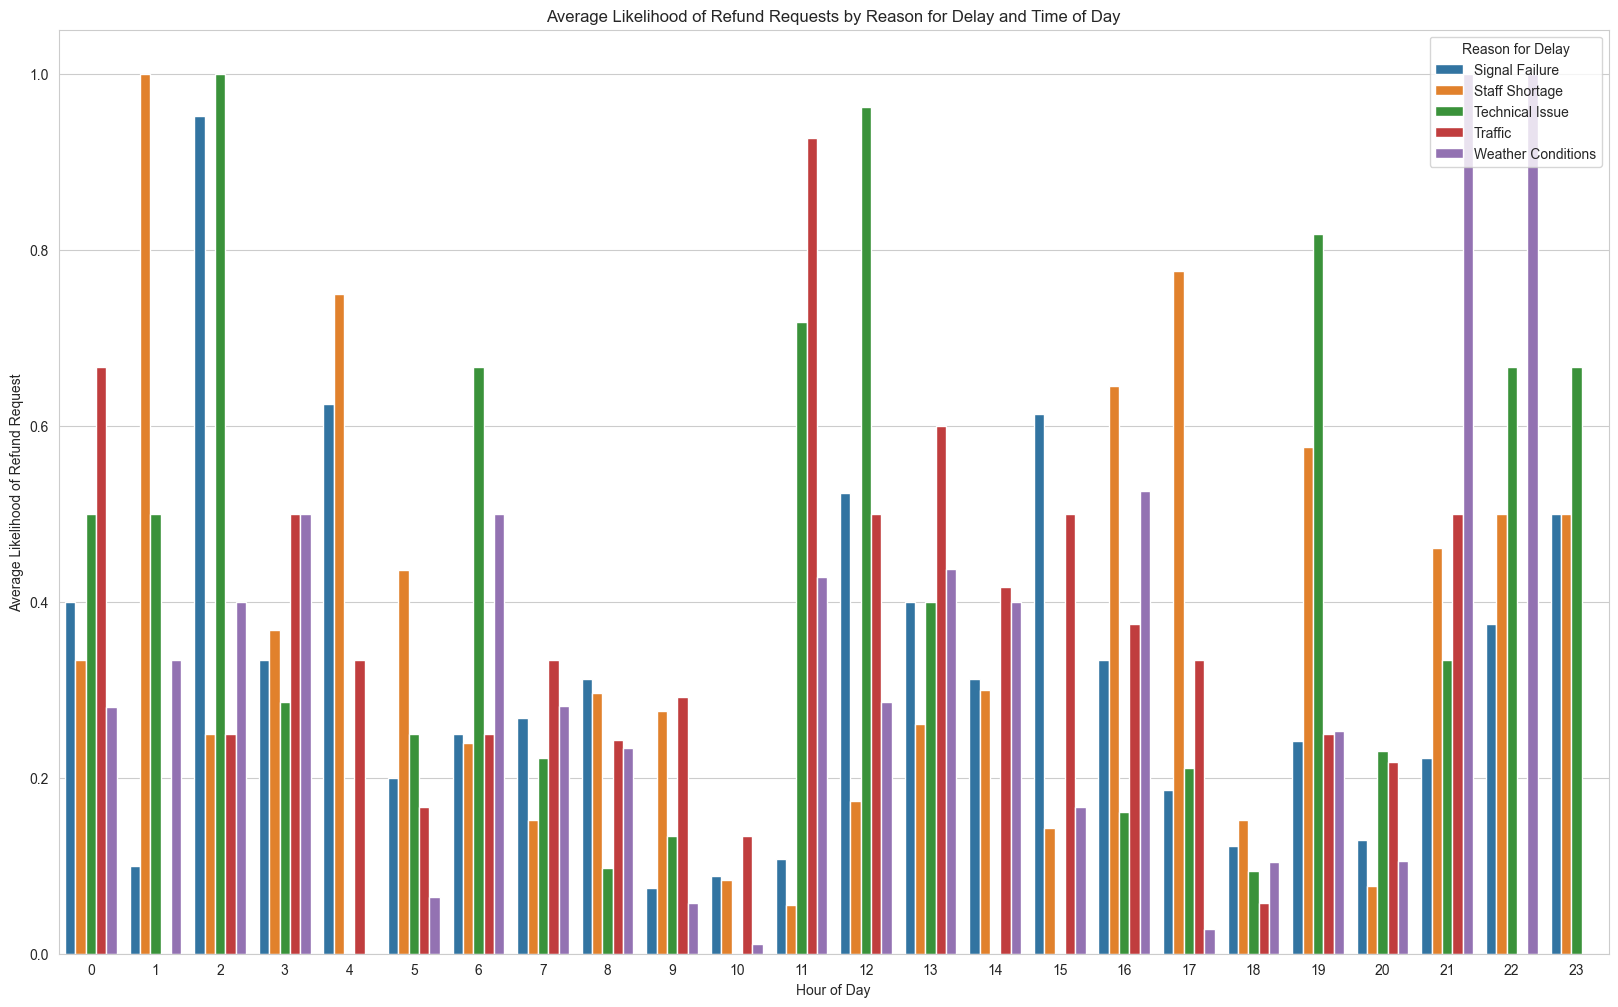

In [55]:
# Group by Reason for Delay and Hour of Day, then calculate the mean of Refund Requested Binary
grouped_refund_df = df.groupby(['Reason for Delay', 'Hour of Day'])['Refund Requested Binary'].mean().reset_index()

# Plotting
plt.figure(figsize=(20, 12))
sns.barplot(data=grouped_refund_df, x='Hour of Day', y='Refund Requested Binary', hue='Reason for Delay')
plt.title('Average Likelihood of Refund Requests by Reason for Delay and Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Likelihood of Refund Request')
plt.legend(title='Reason for Delay')
plt.show()

**Conclusions of relationship between Refund Requests by Reason for Delay and Time of Day:**
Refund requests peak during the early morning (1 AM - 3 AM) and evening hours (7 PM - 11 PM), especially due to Signal Failure, Staff Shortage, and Technical Issues. Signal Failure and Technical Issues consistently result in higher refund requests during off-peak hours, while Staff Shortage shows high variability with peaks in both early morning and evening. Traffic and Weather Conditions have more spread-out patterns and are less predictable.

To reduce refund requests, I would recommend focus on fixing delays during the early morning and late evening improving responses to Signal Failures and Technical Issues during these times.

#### Conclusions

This project has provided a detailed analysis of various aspects of rail travel in England. We have looked at the impact of ticket types, classes of service and railcard use on ticket prices, the distribution of journeys by time of day, and delays, cancellations and refund requests. 

**The main findings and insights from the project are as follows:**

* Ticket type has a more significant impact on cost compared to railcard availability. Advance tickets are cheaper than Anytime and Off-Peak tickets. First Class is two to three times more expensive than Standard Class. Railcard passengers pay less, but the impact is minor. 

* The main peaks of activity are in the morning (06:00-09:00) and evening (18:00-21:00) hours due to the start and end of the working day. To optimize the schedule, it is necessary to increase train frequency during morning and evening hours to meet high demand and decrease train frequency during night hours when activity is minimal. 

* Staff shortages cause the greatest delays around midday, technical problems in the early morning and evening hours. Weather conditions are less predictable but have a meaningful impact on delays. To reduce refund requests, focus on eliminating delays in the early morning and late evening hours by improving response to signal failure and technical problems during these periods.

The insights gained provide important information for optimizing rail transport operations, which will improve passenger services and increase the efficiency of the system as a whole. The following areas can be considered to better understand and improve rail services:
* Studying passenger flow patterns on different days of the week and seasons of the year to better customize train schedules.
* Assessing the impact of weather conditions, holidays and major events on demand and delays to help in more flexible resource management.
* Using simulation models to predict the impact of changes in timetabling, pricing and resource management.

By increasing the depth of analysis, we can create a more sustainable, convenient, and efficient rail transportation system that better meets passenger needs and adapts to change.